# Image Classification using Transfer Learning

In [2]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
#import pets

from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.applications.inception_v3 import InceptionV3

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# Load data

In [33]:
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']
def download_data(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)
            

download_data('data', '.')           
            

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Add label to each image

In [34]:
def image_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        image_name += '.jpg'
        if image_name[0].lower() != image_name[0]:
            class_name = 'cat'
        else:
            class_name = 'dog'
        annotations[image_name] = class_name
    
    return annotations, i + 1


class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = image_annotations('data/annotations/trainval.txt')
test_annot, count_test = image_annotations('data/annotations/test.txt')

print('Training examples count:', count_train)
print('Test examples count:', count_test)

Training examples count: 3680
Test examples count: 3669


# Select images randomly

In [9]:
image_dir = 'data/images/'

def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    indices = np.random.choice(range(total_examples), batch_size)
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []
    
    for i, index in enumerate(indices):
        image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, all_keys[index]),
                                                     target_size=(128, 128))
        images.append(image)
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]
    
    return x, y, images

# Display images

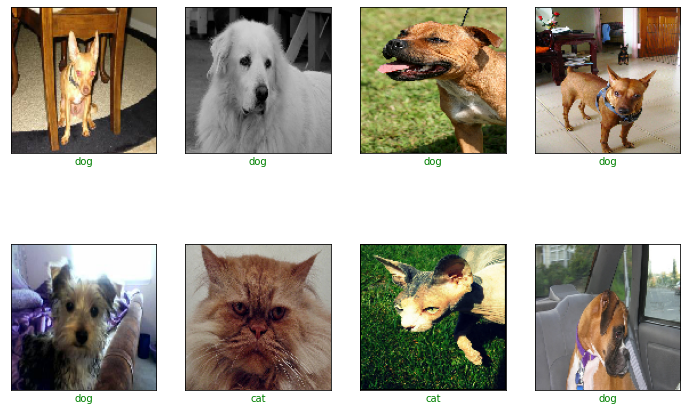

In [39]:
def display_images(x, y, p, images, index_to_class):

    #print('Displaying first 8 examples..')

    if len(images) < 8:
        print('Need at least 8 examples')
        return None

    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        gt = int(np.squeeze(y[i]) > 0.5)
        pred = int(np.squeeze(p[i]) > 0.5)
        col = 'green' if gt == pred else 'red'
        plt.xlabel(index_to_class[pred], color=col)
    return plt


x, y, images = get_random_batch(train_annot, batch_size=8)
display_images(x, y, y, images, index_to_class).show()

# Pre-trained model 

In [12]:
incep = InceptionV3(weights='imagenet', include_top=False,input_shape=(128, 128, 3), pooling='avg')
incep.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Build and compile model

In [22]:
def create_model():
    model = tf.keras.models.Sequential([
        incep,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [23]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield (x, y)

In [37]:
batch_size = 32
steps_per_epoch = int(len(list(train_annot.keys()))/batch_size)
validation_steps = int(len(list(test_annot.keys()))/batch_size)

print('Steps per epoch:', steps_per_epoch)
print('Validation steps:', validation_steps)


Steps per epoch: 115
Validation steps: 114


# Train model

In [38]:
%%time

H = model.fit(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=1
)

115/115 [==============================] - 106s 925ms/step - loss: 0.2378 - acc: 0.9277 - val_loss: 0.1951 - val_acc: 0.9375
Wall time: 1min 46s


# Make predictions

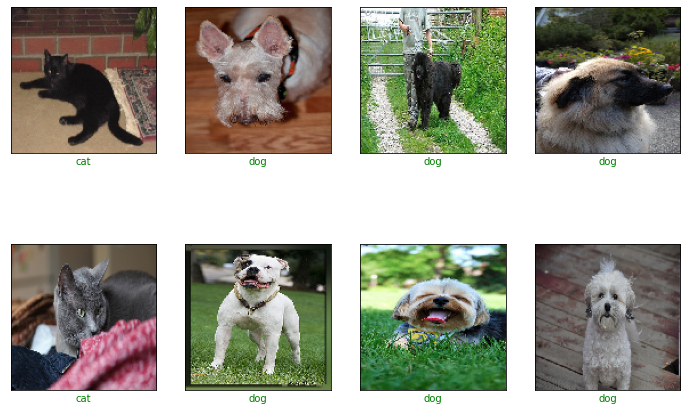

In [40]:
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)
display_images(x, y, preds, images, index_to_class).show()